# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [1]:
ls data

phi_p_0.8/ phi_p_1.2/ phi_p_1.5/ phi_p_1.7/ phi_p_2.0/ phi_p_2.3/


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [2]:
ls data/phi_p_0.8/

Contact_center.txt   contacts.xyz         particle_center.txt
TCC/                 coords.xyz
box.txt              inputparameters.ini


Lengthy and complex algorithms should be stored in the folder `src`

In [3]:
ls src

__pycache__/ geometry.py  io.py


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [1]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from src import io

In [3]:
centres = io.Centres("data/phi_p_0.8/coords.xyz")
contacts = io.Contacts("data/phi_p_0.8/contacts.xyz")

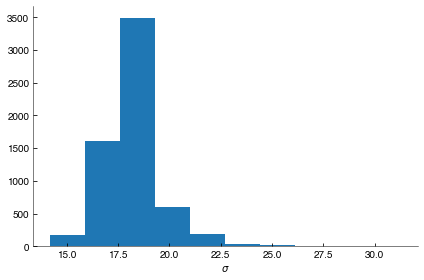

In [4]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [12]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

## Example of analysis

We show hee how we can proceed to explore the data. For example, we get the nearest contacts for every particle centre. To do so, we fix a cutoff radius `rcut` for our search. 

In [5]:
from scipy.spatial import cKDTree

rcut = centres.radius.mean()*1.2
centre_tree = cKDTree(centres.coord)
contact_tree = cKDTree(contacts.coord)
centre_contacts=centre_tree.query_ball_tree(contact_tree, rcut)

By the same means, we can easily estimate the radial distribution function `g(r)`.

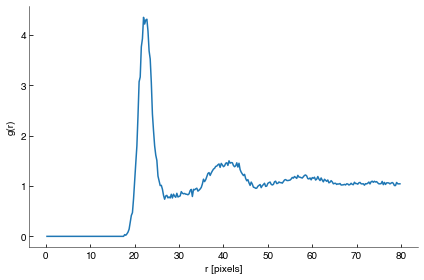

In [6]:
dr =0.25
r = np.arange(dr,80,dr)
nb = centre_tree.count_neighbors(centre_tree,r, cumulative=False)
nb[0]=0 # ignore self-distances
V = np.prod(centres.coord.ptp(axis=0))
N  = centres.coord.shape[0]
g = nb/(4*np.pi*r**2*dr)*V/(N*(N-1))
plt.plot(r,g); plt.xlabel('r [pixels]'); plt.ylabel('g(r)');

Similarly, we can compute the coordination within a larger cutoff, for example around the first minimum of `g(r)`.

In [7]:
rcut = 27
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = [len(n) for n in neighs]

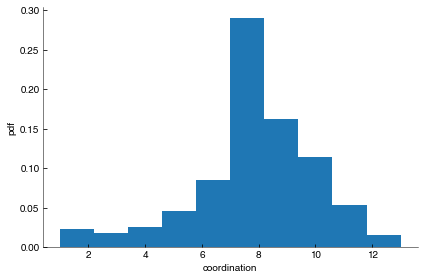

In [8]:
plt.hist(coordination, density=True); plt.xlabel('coordination');plt.ylabel('pdf');

In [9]:
centre_contacts_weights = []
num_contacts = []
for c in centre_contacts:
    w = []
    if len(c)>0:
        w=list(contacts.volume[c])
    
    num_contacts.append(len(c))
    centre_contacts_weights.append(w)

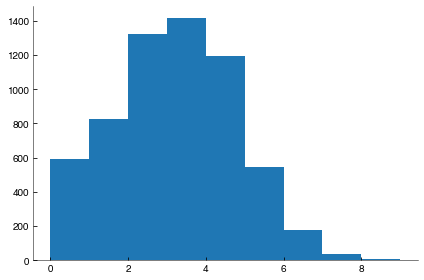

In [10]:
plt.hist(num_contacts,bins=np.arange(10));

## Network construction

We need to find common contacts to construct edges.

In [11]:
from scipy.spatial.distance import cdist

In [12]:
rcut = centres.radius.mean()*2.0
neighs = contact_tree.query_ball_tree(centre_tree,rcut)
closest = []
closest_dists = []
for i,n in enumerate(neighs):
    n = np.array(n)
#     print(i,n
    if len(n)>0:
        dists = np.linalg.norm(centres.coord[n]-contacts.coord[i], axis=1) 
#         print(n,dists,dists.argsort())
        order = dists.argsort()[:2]
        closest.append(n[order])
        closest_dists.append(dists[order])
    else:
        closest.append([])
        closest_dists.append([])

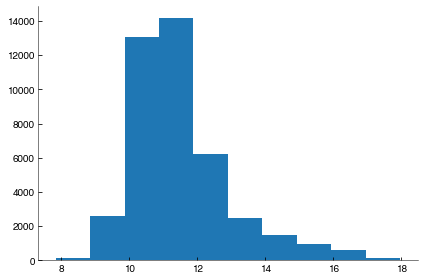

In [13]:
# check the distribution of distances between contacts and centres
dists = np.concatenate(np.array([d for d in closest_dists if len(d)>0]))
plt.hist(dists);

In [14]:
missing = [1 for n in closest if len(n)==0]
sum(missing)

0

In [15]:
closest[0]

array([1765,  520])

In [16]:
import networkx as nx

In [77]:
G = nx.Graph()
min_vol = 200 #very important threshold: it decides how many edges form the network. Thousands of edges quickly become unmanegeable from the plotting point of view
for i,e in enumerate(closest):
    if contacts.volume[i]>min_vol: 
        G.add_edge(e[0],e[1])#,weight=contacts.volume[i])#, weight=contacts.volume[i])
G.number_of_edges()

20590

In [74]:
pos = nx.spring_layout(G)

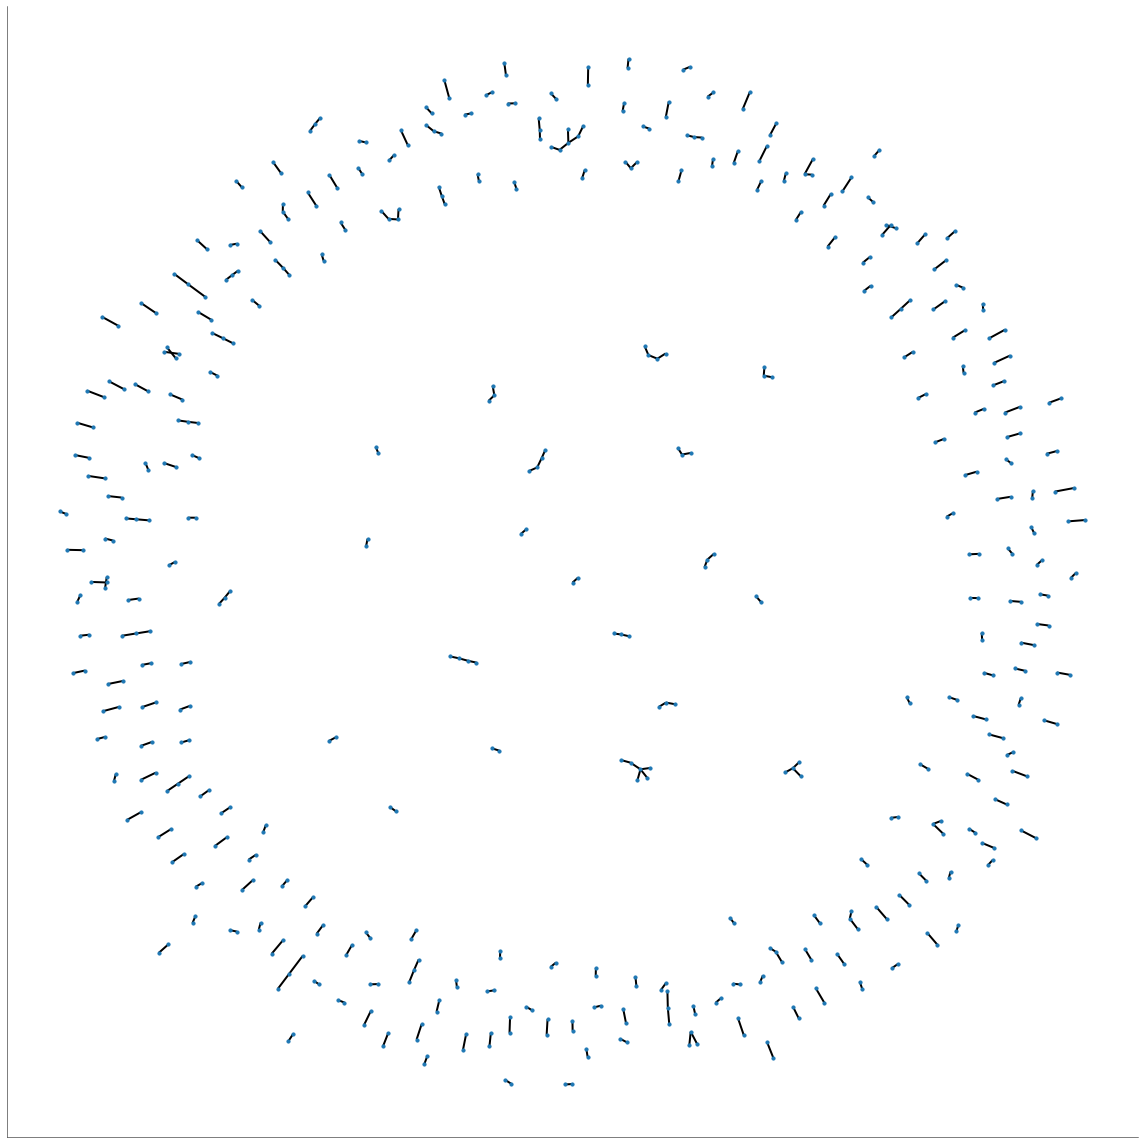

In [75]:
plt.figure(figsize=(16,16))
nx.draw_networkx(G, pos,node_size=10,with_labels=False,width=2)
# plt.xlim(-0.25,0.25)
# plt.ylim(-0.1,0.2)
plt.savefig(f"figs/{G.number_of_edges()}edges.png", dpi=300)

From the Graph we can extract many possible metrics. For exqmple the **deegre assortativity** measures to what extent nodes with similar degrees cluster together (see Newman PRE 67, 026126 􏰒2003􏰀).

In [78]:
nx.degree_assortativity_coefficient(G)

0.3688376941062389

One can compute the **centrality**, which should simply reflect the total number fo contacts

In [85]:
centrality = nx.degree_centrality(G)

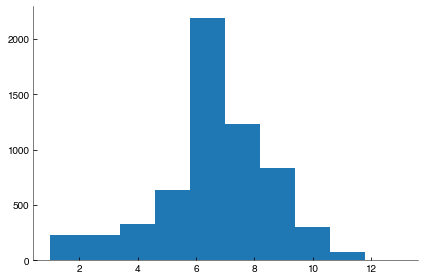

In [86]:
plt.hist(np.array(list(centrality.values()))*G.number_of_nodes());

Simple geometrical measures are also possible, such as the **number of triangles**.

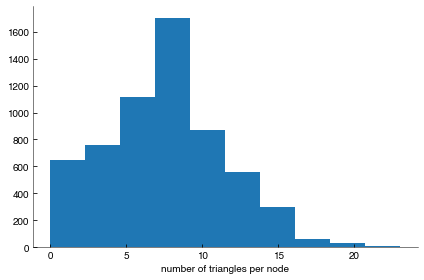

In [87]:
plt.hist(nx.triangles(G).values());
plt.xlabel("number of triangles per node");

We can for example compute the **transitivity** $T$ as
$$T=3 \frac{\# \text { triangles }}{\# \text { triads }}$$
which is $T=1$ for complete graphs (where every pair of nodes is connected by a single edge).

In [88]:
nx.transitivity(G)

0.34355949018152626